# variance reduction techniques

## Iteratively create and utilising a wight window to accelerate the deep shielding simulations

This example implements the Magic method of weight window generation. The theory of weight windows and the method are best described by the paper here https://scientific-publications.ukaea.uk/wp-content/uploads/Published/INTERN1.pdf

In this tutorial we shall focus on generating a weight window to accelerate the simulation of particles through a shield. Then using that weight window to generate a new weight window and repeating the process to obtain a final weight window.

First we must make a model. This is kept as simple as possible as the focus of this notebook is on generating and then using a weight window.

The model is a single sphere of 200 cm radius filled with water and containing a 14MeV point source in the center

In [1]:
import openmc
import openmc_weight_window_generator
# this is a minimal package that adds some functionality to openmc, namely it adds:
# - openmc.StatePoint.generate_wws which we use in a previous task
# - openmc.Model.generate_wws_magic_method which we use in this task


# creates a shielding material
water = openmc.Material(name='Water')
water.set_density('g/cc', 1.0)
water.add_element('H', 2)
water.add_element('O', 1)
materials = openmc.Materials([water])

sphere1 = openmc.Sphere(r=200, boundary_type='vacuum')

region1 = -sphere1

cell1 = openmc.Cell(fill=water, region=region1)

geometry = openmc.Geometry([cell1])

source = openmc.Source()
source.space = openmc.stats.Point((0.0, 0.0, 0.0))
source.angle = openmc.stats.Isotropic()
source.energy = openmc.stats.Discrete([14e6], [1.0])
source.particle = 'neutron'

settings = openmc.Settings()
settings.run_mode = 'fixed source'
settings.source = source
settings.particles = 10000
settings.batches = 10

model = openmc.Model(geometry, materials, settings)

Now we can plot the simple geometry

<Figure size 720x720 with 0 Axes>

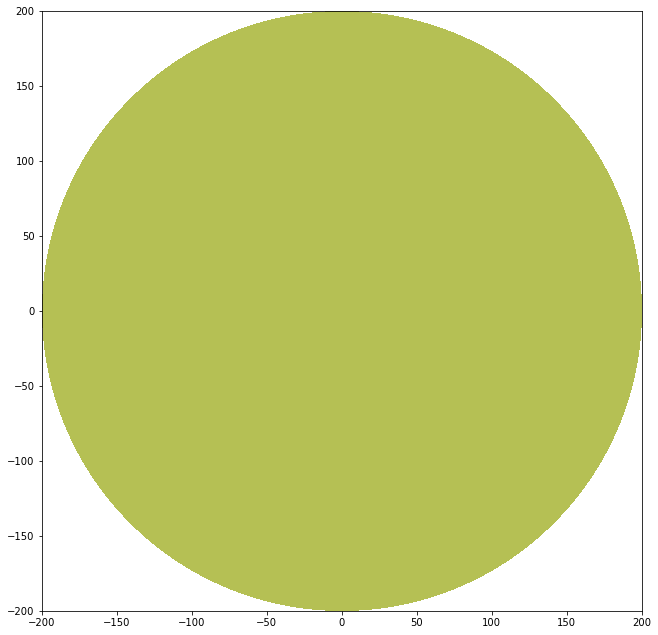

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
model.geometry.root_universe.plot(width=(400, 400), pixels=(600, 600))
plt.show()

Now we shall add a regular mesh tally over the the geometry.

The mesh will be used to record the neutron flux in each mesh voxel

In [3]:
mesh = openmc.RegularMesh()
mesh.lower_left = model.geometry.bounding_box[0]
mesh.upper_right = model.geometry.bounding_box[1]
mesh.dimension = (50, 50, 50)

mesh_filter = openmc.MeshFilter(mesh)

flux_tally = openmc.Tally(name='flux tally')
flux_tally.filters = [mesh_filter]
flux_tally.scores = ['flux']

# adds the mesh tally to the model
model.tallies = [flux_tally]

output_file = model.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

Now we can plot the flux and the standard deviation of the flux tally to see how far into the shield the neutrons got. 

/home/jshimwell/openmc_my_fork/openmc/tallies.py:1255: RuntimeWarning: invalid value encountered in true_divide
  data = self.std_dev[indices] / self.mean[indices]


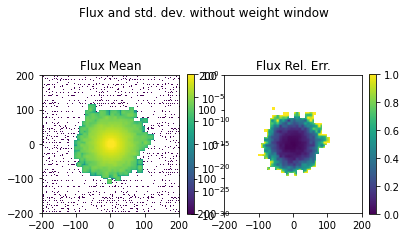

In [4]:
from matplotlib.colors import LogNorm

with openmc.StatePoint(output_file) as sp:
    flux_tally = sp.get_tally(id=flux_tally.id)

llc, urc = model.geometry.bounding_box

fig,  (ax1, ax2) = plt.subplots(1,2)
fig.suptitle('Flux and std. dev. without weight window')

slice_index = int(mesh.dimension[-1]/2)

# create a plot of the mean values
flux_mean = flux_tally.mean.reshape(*mesh.dimension)
img1 = ax1.imshow(flux_mean[slice_index], origin='lower', extent=(llc[0], urc[0], llc[1], urc[1]), norm=LogNorm())
ax1.set_title('Flux Mean')
plt.colorbar(img1, ax=ax1, fraction=0.046)
img1.set_clim(vmin=1e-30, vmax=1.0)

# create a plot of the flux relative error
flux_rel_err = flux_tally.get_values(value='rel_err').reshape(*mesh.dimension)
img2 = ax2.imshow(flux_rel_err[slice_index], origin='lower', extent=(llc[0], urc[0], llc[1], urc[1]))
ax2.set_title('Flux Rel. Err.')
plt.colorbar(img2, ax=ax2, fraction=0.046)
# ax2.set_colorbar(img2, ax=ax2)
img2.set_clim(vmin=0.0, vmax=1.0)

plt.show()

Now we shall run the simulation several times, with each iteration we shall use the flux tally to produce a weight window. Then the weight window will be used in the subsequent simulation.

In [ ]:
model.generate_wws_magic_method(tally=flux_tally, iterations=5, max_split=500_000)

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

/home/jshimwell/openmc_my_fork/openmc/tallies.py:1255: RuntimeWarning: invalid value encountered in true_divide
  data = self.std_dev[indices] / self.mean[indices]


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

/home/jshimwell/openmc_my_fork/openmc/tallies.py:1255: RuntimeWarning: invalid value encountered in true_divide
  data = self.std_dev[indices] / self.mean[indices]


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

/home/jshimwell/openmc_my_fork/openmc/tallies.py:1255: RuntimeWarning: invalid value encountered in true_divide
  data = self.std_dev[indices] / self.mean[indices]


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

/home/jshimwell/openmc_my_fork/openmc/tallies.py:1255: RuntimeWarning: invalid value encountered in true_divide
  data = self.std_dev[indices] / self.mean[indices]


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

Now we can plot the flux and the standard deviation of the flux tally to see how far into the shield the neutrons got. 

In [ ]:
from matplotlib.colors import LogNorm

with openmc.StatePoint(output_file) as sp:
    flux_tally = sp.get_tally(id=flux_tally.id)

llc, urc = model.geometry.bounding_box

fig,  (ax1, ax2) = plt.subplots(1,2)
fig.suptitle('Flux and std. dev. without weight window')

slice_index = int(mesh.dimension[-1]/2)

# create a plot of the mean values
flux_mean = flux_tally.mean.reshape(*mesh.dimension)
img1 = ax1.imshow(flux_mean[slice_index], origin='lower', extent=(llc[0], urc[0], llc[1], urc[1]), norm=LogNorm())
ax1.set_title('Flux Mean')
plt.colorbar(img1, ax=ax1, fraction=0.046)
img1.set_clim(vmin=1e-30, vmax=1.0)

# create a plot of the flux relative error
flux_rel_err = flux_tally.get_values(value='rel_err').reshape(*mesh.dimension)
img2 = ax2.imshow(flux_rel_err[slice_index], origin='lower', extent=(llc[0], urc[0], llc[1], urc[1]))
ax2.set_title('Flux Rel. Err.')
plt.colorbar(img2, ax=ax2, fraction=0.046)
# ax2.set_colorbar(img2, ax=ax2)
img2.set_clim(vmin=0.0, vmax=1.0)

plt.show()